In [1]:
!pip install Pillow matplotlib


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
from torch.utils.data import random_split
import torch.nn as nn

In [4]:
dataset_path = '/kaggle/input/abo-images-small/dataset.csv'
# images_zip_path = '/content/drive/MyDrive/ml_data/multi-task-category-prediction/abo-images-small.tar'
# destination_path = '/content/drive/MyDrive/ml_data/multi-task-category-prediction/data2/'
image_path = '/kaggle/input/abo-images-small/abo-images-small/images/small/'
# checkpoint_path = '/content/drive/MyDrive/ml_data/multi-task-category-prediction/'

In [5]:
# import tarfile
# import os
# from tqdm import tqdm

# def extract_tar_file(tar_file_path, destination_path):
#     # make a directory if it doesnot exist
#     if not os.path.exists(destination_path):
#         os.makedirs(destination_path)

#     # open tar file in read mode
#     with tarfile.open(tar_file_path, "r") as tar:
#         members = tar.getmembers()
#         total_files = len(members)

#         # use tqdm to track progress
#         with tqdm(total=total_files, desc="Extracting files", unit="file") as pbar:
#             for member in members:
#                 tar.extract(member, path=destination_path)  # Extract each member
#                 pbar.update(1)  # Increase progress bar

#     print(f'Extracted all files to: {destination_path}')

In [6]:
# extract_tar_file(images_zip_path, destination_path)

In [7]:
from matplotlib import pyplot as plt
from PIL import Image

def show_image(image_url):
    # Load the image using PIL
    img = Image.open(image_url)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

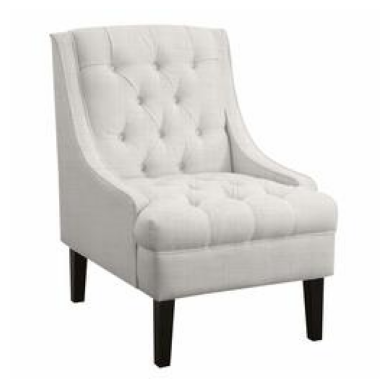

In [8]:
show_image(f'{image_path}35/35bc14eb.jpg')

In [9]:
class MultiLabelImageDataset(Dataset):
    def __init__(self, file_path, img_dir, transform=None):
        # read csv file
        self.data = pd.read_csv(file_path)
        self.img_dir = img_dir
        self.transform = transform

        # convert category labels to unique indices
        self.category_labels = {}
        for i in range(1, 7):
            column_name = f'category_{i}'
            self.data[column_name] = self.data[column_name].fillna('UNK')
            self.data[f'{column_name}_idx'] = self.data[column_name].astype('category').cat.codes
            self.category_labels[column_name] = dict(enumerate(self.data[column_name].astype('category').cat.categories))

        self.num_categories = 6

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 2])
        # some of the dataset images are in bw (1, 224, 224)
        # to address this inconsistency and convert all of them into rgb (3, 224, 224)
        image = Image.open(img_name).convert('RGB')

        labels = []
        for i in range(1, 7):
            labels.append(self.data.iloc[idx, -(self.num_categories - (i - 1))])

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(labels)

In [10]:
torch.cuda.is_available()

True

In [11]:
# the following transformation reshapes the images to 224x224
# and the transformations are meant to make the learning a bit generalized
# these small changes might help model learn better
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

batch_size = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
device

'cuda'

In [13]:
dataset = MultiLabelImageDataset(dataset_path, image_path, transform=transform)

In [14]:
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)  # 70% training
dev_size = int(0.15 * dataset_size)   # 15% validation
test_size = dataset_size - train_size - dev_size  # 15% test

# randomly split the dataset
train_dataset, dev_dataset, test_dataset = random_split(dataset, [train_size, dev_size, test_size])

In [15]:
# DataLoaders for each dataset
# shuffling makes sure the same batches are not repeated in each epoch
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [27]:
from collections import Counter

In [37]:
# most frequent baseline 

category_frequencies = [Counter() for _ in range(6)]

for _, labels in train_dataloader:
    for i in range(6):
        category_frequencies[i].update(labels[:, i].tolist())
        
most_frequent_categories = [category_frequency.most_common(1)[0][0] for category_frequency in category_frequencies]

In [39]:
most_frequent_categories

[48, 267, 971, 699, 130, 10]

In [98]:
class BaselineClassifier(nn.Module):
    def __init__(self, most_frequent_labels):
        super(BaselineClassifier, self).__init__()
        self.labels = most_frequent_labels
    
    def forward(self, x):
        return torch.tensor([self.labels for _ in range(len(x))])
    
    def predict(self, x):
        return self.forward(x)

In [113]:
class MultiTaskCNN(nn.Module):
    def __init__(self, num_classes_list):
        super(MultiTaskCNN, self).__init__()

        # this is feature extraction block
        # model learns to make a representation for all the task layers to use
        # this is inspired by alexnets architecture
        # this can be considered as an encoder 
        self.conv_block = nn.Sequential(
            # first layer
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # second layer
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # third layer
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(),

            # fourth layer
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(),

            # fifth layer
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # this takes in the encoder layers output and flattens it
        # dropout is introduced to make model learn better 
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 4096), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

        # classifier layer for each task
        # since each classification has its own unique possible outputs, 
        # we take the count for each class as input in model instantiation
        self.classifiers = nn.ModuleList([nn.Linear(4096, num_classes) for num_classes in num_classes_list])

    def forward(self, x):
        # encode
        x = self.conv_block(x)
        x = self.fc_block(x)
        
        # decode each task
        outputs = [classifier(x) for classifier in self.classifiers]
        return outputs

In [90]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

In [114]:
# the evaluate function takes in model, data to evaluate, criterion to evaluate with and device 
# it computes loss per task, total combined loss, accuracy per task, f1 per task and returns them as a dictionary

def evaluate(model, data_loader, criterion = None, device = 'cpu'):
    # loading eval mode to not use dropouts and batchnorms
    model.eval()  
    
    total_loss = 0
    individual_losses = [0] * 6  
    accuracy = [0] * 6
    f1_scores = [0] * 6 
    all_labels = [[] for _ in range(6)]  # ground truth
    all_predictions = [[] for _ in range(6)] # predictions
    
    with torch.no_grad():  
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            batch_losses = []
            for i in range(6):
                if criterion:
                    loss = criterion[i](outputs[i], labels[:, i].long())
                    individual_losses[i] += loss.item() * images.size(0)
                    batch_losses.append(loss.item())
                
                _, predicted = torch.max(outputs[i], 1)
                # fix for error in accuracy_score, f1_score functions
                # convert to numpy list 
                all_labels[i].extend(labels[:, i].cpu().numpy())
                all_predictions[i].extend(predicted.cpu().numpy())
            
            combined_loss = sum(batch_losses)
            total_loss += combined_loss

    avg_individual_losses = [loss / len(data_loader.dataset) for loss in individual_losses]
    avg_combined_loss = total_loss / len(data_loader.dataset)
    for i in range(6):
        accuracy[i] = accuracy_score(all_labels[i], all_predictions[i],)
        f1_scores[i] = f1_score(all_labels[i], all_predictions[i], average='weighted')
    
    return avg_individual_losses, avg_combined_loss, accuracy, f1_scores

In [115]:
# the evaluate function takes in model, data to evaluate, criterion to evaluate with and device 
# it computes loss per task, total combined loss, accuracy per task, f1 per task and returns them as a dictionary

def evaluate_baseline(model, data_loader, device='cpu'):
    # loading eval mode to not use dropouts and batchnorms
    model.eval()  
    
    accuracy = [0] * 6
    f1_scores = [0] * 6 
    all_labels = [[] for _ in range(6)]  # ground truth
    all_predictions = [[] for _ in range(6)] # predictions
    
    with torch.no_grad():  
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            predicted = model.predict(images)
            
            for i in range(6):
                # fix for error in accuracy_score, f1_score functions
                # convert to numpy list 
                all_labels[i].extend(labels[:, i].cpu().numpy())
                all_predictions[i].extend(predicted[:, i].cpu().numpy())

    for i in range(6):
        accuracy[i] = accuracy_score(all_labels[i], all_predictions[i],)
        f1_scores[i] = f1_score(all_labels[i], all_predictions[i], average= 'weighted')

    
    return accuracy, f1_scores

In [116]:
# function to train the model and return losses over epochs
# the following approach uses loss over training data per each task to update its corresponding contribution to total loss
def train(model, data_loader, validation_data_loader, optimizer, num_epochs = 10, criterion = []):
    individual_loss_per_epoch = []
    combined_loss_per_epoch = []
    accuracy_per_epoch = []
    f1_score_per_epoch = []
    
    task_weights = [1.0 for _ in range(6)]
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        task_losses = [0.0] * 6

        for images, labels in data_loader:
            # move data to GPU
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad() 
            cat = model(images)
            
            losses = []
            for i in range(6):
                loss = criterion[i](cat[i], labels[:, i].long())
                weighted_loss = task_weights[i] * loss
                losses.append(loss)
                task_losses[i] += loss.item() * images.size(0)
                
            total_loss = sum(losses)
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item() * images.size(0)
            
        # update task weights based on epoch individual losses
        avg_task_losses = [task_loss / len(data_loader.dataset) for task_loss in task_losses]
        max_loss = max(avg_task_losses) if max(avg_task_losses) > 0 else 1
        task_weights = [max_loss / (task_loss if task_loss > 0 else max_loss) for task_loss in avg_task_losses]

        epoch_loss = running_loss / len(train_dataloader.dataset)

        # evaluate after each epoch
        individual_loss, combined_loss, accuracy, f1_score = evaluate(model, validation_data_loader, [nn.CrossEntropyLoss().to(device) for _ in range(6)], device)

        individual_loss_per_epoch.append(individual_loss)
        combined_loss_per_epoch.append(combined_loss)
        accuracy_per_epoch.append(accuracy)
        f1_score_per_epoch.append(f1_score)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}')
        # save model weight for each 10th epoch
        if((epoch+1)%10 == 0):
            torch.save(model.state_dict(), f'vgg_like_adam_epoch_{epoch}.pth')

    return {
    "individual_loss_per_epoch": individual_loss_per_epoch,
    "combined_loss_per_epoch": combined_loss_per_epoch,
    "accuracy_per_epoch": accuracy_per_epoch,
    "f1_score_per_epoch": f1_score_per_epoch
}

In [105]:
# evaluating baseline classifier

baseline_model = BaselineClassifier(most_frequent_categories)
evaluate_baseline(baseline_model, dev_dataloader)

([0.21579391891891891,
  0.11402027027027027,
  0.1891891891891892,
  0.6583614864864865,
  0.9636824324324325,
  0.9983108108108109],
 [0.07660346826506952,
  0.023340009835460935,
  0.06019656019656019,
  0.5227326495708848,
  0.945859488520779,
  0.9974669301592379])

In [117]:
import torch.optim as optim
import torch.nn.functional as F

# loss for each auxiliary task
criterion = [nn.CrossEntropyLoss().to(device) for _ in range(6)]

# num of possible categories
num_classes_list = [len(train_dataset.dataset.data[f'category_{i+1}'].astype('category').cat.categories) for i in range(6)]

# Instantiate the model
model = MultiTaskCNN(num_classes_list)
model.to(device)

# tried different optimizers like sgd and adagrad
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [118]:
# unique categories per each level

num_classes_list

[146, 465, 1039, 749, 138, 11]

In [119]:
results = train(model= model, data_loader= train_dataloader, validation_data_loader= dev_dataloader,optimizer= optimizer, criterion= criterion, num_epochs= 10 )

Epoch [1/10], Loss: 19.290845643532478
Epoch [2/10], Loss: 15.539912050906905
Epoch [3/10], Loss: 14.653797050261405
Epoch [4/10], Loss: 13.586041544030115
Epoch [5/10], Loss: 12.671429026324232
Epoch [6/10], Loss: 11.820258718911829
Epoch [7/10], Loss: 10.951448765575837
Epoch [8/10], Loss: 10.305928633222319
Epoch [9/10], Loss: 9.603771234307152
Epoch [10/10], Loss: 9.056710941504862


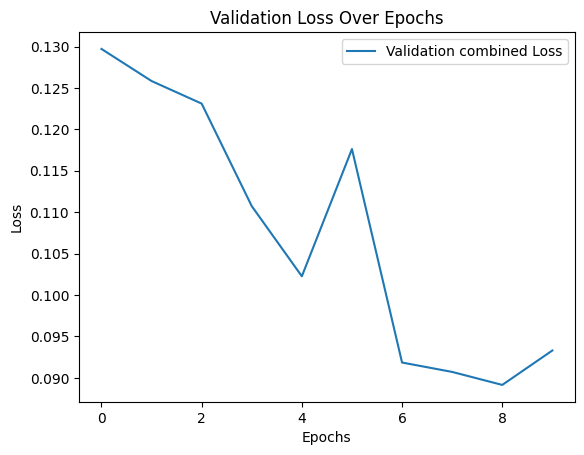

In [120]:
# plotting loss on dev data per epoch during training

plt.plot(results['combined_loss_per_epoch'], label='Validation combined Loss')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('validation_loss_over_epochs.png')
plt.show()

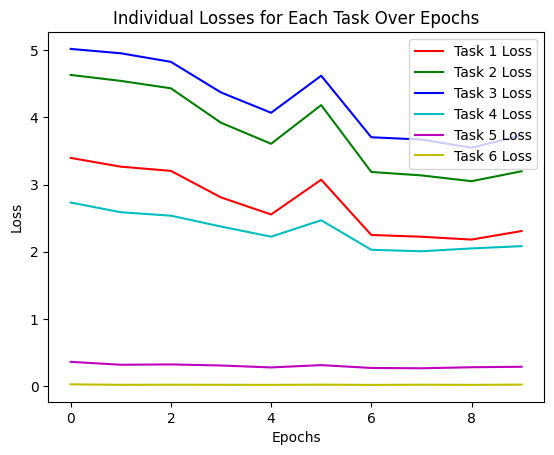

In [121]:
# plotting loss on dev data per task per epoch during training

colors = ['r', 'g', 'b', 'c', 'm', 'y']  
for i in range(6):
    task_losses = [loss[i] for loss in results["individual_loss_per_epoch"]]  
    plt.plot(task_losses, color=colors[i], label=f'Task {i+1} Loss')

plt.title('Individual Losses for Each Task Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('individual_task_loss_per_epoch.png')
plt.show()

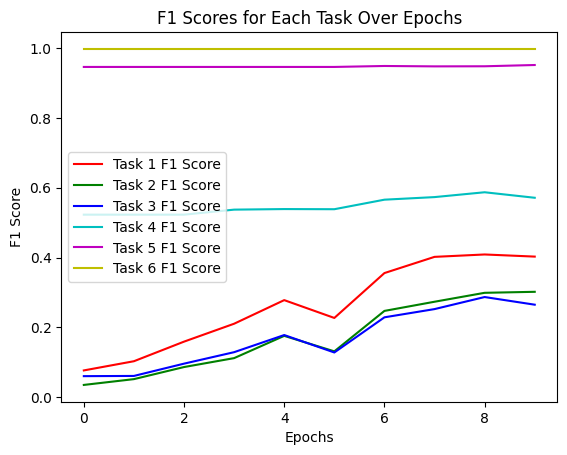

In [122]:
#plot f1 scores for each task per epoch during training

for i in range(6):
    task_f1_scores = [f1[i] for f1 in results['f1_score_per_epoch']]  
    plt.plot(task_f1_scores, color=colors[i], label=f'Task {i+1} F1 Score')

plt.title('F1 Scores for Each Task Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.savefig('f1_per_epoch.png')
plt.show()

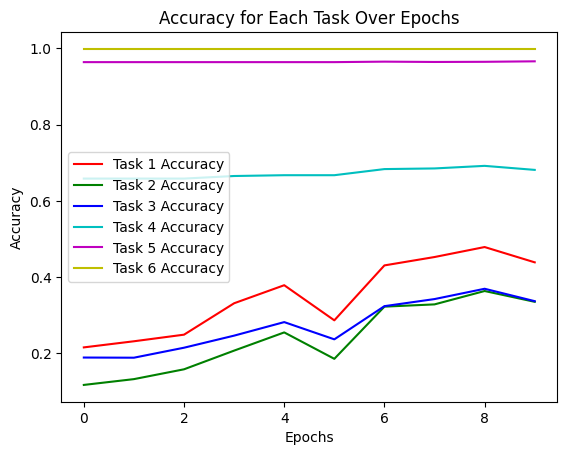

In [123]:
# plot accuracy for each task per epoch during training

for i in range(6):
    task_accuracies = [acc[i] for acc in results['accuracy_per_epoch']]  #
    plt.plot(task_accuracies, color=colors[i], label=f'Task {i+1} Accuracy')

plt.title('Accuracy for Each Task Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_per_epoch.png')
plt.show()

In [124]:
# evaluating model on test data

evaluate(model,test_dataloader,[nn.CrossEntropyLoss().to(device) for _ in range(6)],device)

([2.2860542212860495,
  3.193820521398939,
  3.6417587563961367,
  1.9979715737612438,
  0.23304463401122436,
  0.007615416262393134],
 0.0911846804410958,
 [0.459915611814346,
  0.3628691983122363,
  0.37468354430379747,
  0.7016877637130802,
  0.9683544303797469,
  0.9995780590717299],
 [0.4181107466145812,
  0.323329147418426,
  0.29987844902212807,
  0.5988740648388361,
  0.9558712891306328,
  0.9993671331255237])

In [125]:
# saving model weights

torch.save(model.state_dict(), f'vgg_varying_weights_10_epochs.pth')